# MNIST Classifier

* Written for the Manning Live Project - ["Semi supervised deep learning with gans for melanoma detection"](https://liveproject.manning.com/project/146/29/semi-supervised-deep-learning-with-gans-for-melanoma-detection)
* Uses a Convolutional Neural Network
* Topology of the CNN - 2 convolutional layers, 2 pooling layers, one fully connected layer, one dropout layer
* Accuracy - 99.3%
* Training time - circa 10mins on my local notebook

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils import data
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
data_set_path = '../Datasets'

# For consistent results
torch.manual_seed(12321)

# Hyper parameters
batch_size = 32
epochs = 20
lr = 0.003
momentum = 0.9

## Download data to Google Colab

* Download data from Google Drive to local Google Colab disk
* Allows the code to pickup the data as if it is running locally

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/GDrive')

# Adjust data set path to match where the data has been loaded
data_set_path = '/GDrive/MyDrive/Datasets'

## Allow it to run on the GPU

* Code below detects if a GPU is available - if it is will run model on GPU

In [6]:
if torch.cuda.is_available():
   print("Notebook is configured to run on the GPU!")
else:
   print("Notebook is currently running on the CPU.")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Notebook is currently running on the CPU.


## Data loader

In [7]:
def get_splits(dataset, percentage_train):
    len_train_set = len(dataset)
    train_set = int(len_train_set*percentage_train)
    val_set = len_train_set - train_set
    return train_set, val_set


def data_loader(batch_size):
    # ToTensor - Converts a PIL Image to a tensor
    # Normalize - normalizes the data. The first parameter is the desired
    # mean. And the second parameter the desired standard deviation
    # Both the mean and standard deviation are vectors - each element
    # of the vector corresponds to one "channel"
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                    ])

    # Dataset is hosted on a private website. And the website is down
    # So instead always rely on local copy - downloaded from GitHub mirror https://github.com/mkolod/MNIST
    # http://yann.lecun.com/exdb/mnist/
    # Images are black and white 28 x 28 pixel images
    # 60,000 images in the training set. 10,000 images in the test set
    # Images are returned as PIL images
    # Train - loads training database

    train_set = datasets.MNIST(data_set_path, download=True, train=True, transform=transform)
    # Trainset contains targets - a vector of 60,000 values and data [60000, 28, 28]

    train_set_len, val_set_len = get_splits(train_set, 0.9)
    train_set, val_set = data.random_split(train_set, [train_set_len, val_set_len])
  
    test_set = datasets.MNIST(data_set_path, download=True, train=False, transform=transform)
    # Testset contains targets - a vector of 10,000 values and data [10000, 28, 28]

    # Loaders are iterables over datasets
    # Batch size is the number of rows per iteration
    # The standard gradient descent algorithm looks at the error of all data points, and steps
    # based on the derivative of the total error.
    # The stochastic gradient descent (SGD) looks at the error of a batch of points and steps
    # based on the derivative of that partial error. The batch is chosen at random

    # The loaders support SGD by batching and randomising the order of batches

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = data_loader(batch_size)

## Loss function

* Use the negative log likelihood loss function
* Loss function is a measure of the error - like mean squared error
or hinge loss (used for SVM)
* Negative log likelihood needs log probabilities which LogSoftMax serves up
* Rather than train our model on a binary classification - right/wrong - instead
we are training our model to give accurate probabilities of the chance of success
* Cross entropy loss is the same as negative log likelihood, but the soft max layer
is taken care of automatically
* Confident but wrong predictions are heavily penalised

In [8]:
def loss_function():
    return nn.NLLLoss()

criterion = loss_function()

## Model

* 32 - 3 x 3 square convolutions 
* RELU layer (rectifier linear unit - max(0, x))
* 2 x 2 pooling layer
* 64 - 3 x 3 square convolutions 
* RELU layer 
* 2 x 2 pooling layer
* Fully connected linear layer - 1600 nodes
* Dropout layer - to help reduce overfitting
* Output layer 10 nodes
* LogSoftmax layer on top of the output nodes


* Softmax converts the output layer into probabilities proportional to the exponent of the input numbers
* LogSoftMax is the log of this

In [9]:
def create_model():
    return nn.Sequential(
              nn.Conv2d(1, 32, (3, 3)),
              # Parameters 32 * 9 = 288
              # Output 32 images that are 26 x 26
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              # Output 32 images that are 13 x 13

              nn.Conv2d(32, 64, (3, 3)),
              # Parameters 64 * 9 = 576
              # Output 64 images that are 11 x 11
              nn.ReLU(),
              nn.MaxPool2d((2, 2)),
              # Output 64 images that are 5 x 5 = 1600

              nn.Flatten(),
              nn.Linear(1600, 128),
              nn.Dropout(0.5),
              nn.Linear(128, 10),
              nn.LogSoftmax(dim=1)
            )

model = create_model().to(device)

## Validation

* Validates model agains the test set

In [10]:
def validate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

## Train model


* Validate after each epoc but does not use the test error to influence training
* Return arrays of training loss and validation as each epoc is added

In [12]:
def train(model, criterion, train_loader, val_loader, lr, epochs, momentum):
    # Each iteration of the loader serves up a pair (images, labels)
    # The images are [64, 1, 28, 28] and the labels [64]
    # The batch size is 64 images and the images are 28 x 28.
    losses = []
    val_errors = []

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for e in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            # As data streams off the loader, push it onto the GPU so the
            # calculation happens on the GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # zeros all the gradients of the weights
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            # Calculates all the gradients via backpropagation
            loss.backward()

            # Adjust weighs based on the gradients
            optimizer.step()

            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        val_error = validate(model, test_loader)

        print("\nEpocs: ", e + 1)
        print("Loss: ", loss)
        print("Validation error: ", val_error)
        losses.append(loss)
        val_errors.append(val_error)

    return losses, val_errors

In [13]:
losses, val_error = train(model, criterion, train_loader, test_loader, lr, epochs, momentum)


Epocs:  1
Loss:  0.32169698929398705
Validation error:  0.9727

Epocs:  2
Loss:  0.09684978273473195
Validation error:  0.9799

Epocs:  3
Loss:  0.07511904256024411
Validation error:  0.9857

Epocs:  4
Loss:  0.060025272655267144
Validation error:  0.9857

Epocs:  5
Loss:  0.05180526993488336
Validation error:  0.9884

Epocs:  6
Loss:  0.0459567877874588
Validation error:  0.9901

Epocs:  7
Loss:  0.04196664788433861
Validation error:  0.9898

Epocs:  8
Loss:  0.03677830239554444
Validation error:  0.9888

Epocs:  9
Loss:  0.03372187221929212
Validation error:  0.9912

Epocs:  10
Loss:  0.030603656648175003
Validation error:  0.9903

Epocs:  11
Loss:  0.027603853272469104
Validation error:  0.9907

Epocs:  12
Loss:  0.02694045737092746
Validation error:  0.9889

Epocs:  13
Loss:  0.024432439502863192
Validation error:  0.9915

Epocs:  14
Loss:  0.02169789968787703
Validation error:  0.9919

Epocs:  15
Loss:  0.021339958517547483
Validation error:  0.9913

Epocs:  16
Loss:  0.019113666

## Effect of increasing training

* Shows the impact of training loss and validation error of increasing the number of epocs

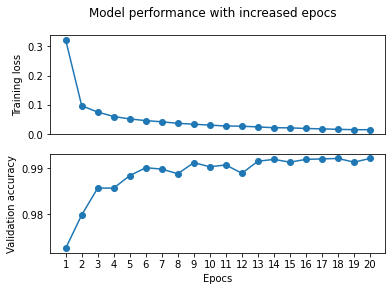

In [15]:
def show_loss_errors(losses, test_errors):
    n = len(losses)
    x_axis = range(1, n+1)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Model performance with increased epocs')

    ax1.plot(x_axis, losses, 'o-')
    ax1.set_ylabel('Training loss')
    ax1.xaxis.set_visible(False)

    ax2.plot(x_axis, test_errors, 'o-')
    ax2.set_ylabel('Validation accuracy')

    ax2.set_xlabel('Epocs')
    plt.xticks(x_axis)

    plt.show()
    
show_loss_errors(losses, val_error)

## Overal performance

In [17]:
opt_epochs = np.argmax(val_error) + 1
model = create_model()
train(model, criterion, train_loader, val_loader, lr, opt_epochs, momentum)
test_error = validate(model, test_loader)

print("Number of epocs: ", opt_epochs)
print("Best test accuracy:", test_error)


Epocs:  1
Loss:  0.3223254459380984
Validation error:  0.9742

Epocs:  2
Loss:  0.09831690823800544
Validation error:  0.9809

Epocs:  3
Loss:  0.07354483098458302
Validation error:  0.9854

Epocs:  4
Loss:  0.062137285393791854
Validation error:  0.9877

Epocs:  5
Loss:  0.052513314097108965
Validation error:  0.9869

Epocs:  6
Loss:  0.04728323276931535
Validation error:  0.9883

Epocs:  7
Loss:  0.041116313432652
Validation error:  0.9897

Epocs:  8
Loss:  0.03721798049254697
Validation error:  0.9905

Epocs:  9
Loss:  0.03463320879948468
Validation error:  0.988

Epocs:  10
Loss:  0.0312518314201185
Validation error:  0.9907

Epocs:  11
Loss:  0.030047277227585562
Validation error:  0.9898

Epocs:  12
Loss:  0.02739238047092948
Validation error:  0.9904

Epocs:  13
Loss:  0.02448095276682252
Validation error:  0.9904

Epocs:  14
Loss:  0.02287030293457056
Validation error:  0.9902

Epocs:  15
Loss:  0.02151191112125808
Validation error:  0.9909

Epocs:  16
Loss:  0.020121765926695